In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout
import math
from sklearn.metrics import mean_squared_error

In [28]:
X_train = pd.read_csv('../../data/input_data_splits/aapl_X_train.csv')
y_train = pd.read_csv('../../data/input_data_splits/aapl_y_train.csv')
X_dev = pd.read_csv('../../data/input_data_splits/aapl_X_dev.csv')
y_dev = pd.read_csv('../../data/input_data_splits/aapl_y_dev.csv')
X_test = pd.read_csv('../../data/input_data_splits/aapl_X_test.csv')
y_test = pd.read_csv('../../data/input_data_splits/aapl_y_test.csv')

X_train['Date'] = pd.to_datetime(X_train['Date'])
X_train.set_index('Date', inplace=True)

X_dev['Date'] = pd.to_datetime(X_dev['Date'])
X_dev.set_index('Date', inplace=True)

X_test['Date'] = pd.to_datetime(X_test['Date'])
X_test.set_index('Date', inplace=True)

y_train = y_train['Close']
y_dev = y_dev['Close']
y_test = y_test['Close']

X_test_copy = X_test.copy()

In [29]:
# Parameters
lookback = 5
n_features = 25

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_dev_scaled = scaler_X.fit_transform(X_dev)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_dev_scaled = scaler_y.fit_transform(y_dev.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback + 1):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback-1])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_dev, y_dev = create_sequences(X_dev_scaled, y_dev_scaled, lookback)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, lookback)

print(X_test.shape)
print(y_test.shape)



(227, 5, 25)
(227, 1)


In [30]:
# %%
import tensorflow as tf
import random
from itertools import product
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings("ignore")

# %%
# Set Random Seeds for Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# %%
# Define Hyperparameter Grid
hyperparameter_grid = {
    'units': [50, 100],          # Number of LSTM units
    'dropout': [0.1, 0.2],       # Dropout rates
    'batch_size': [16, 32],      # Batch sizes
    'epochs': [20, 50],          # Number of epochs
}

# Create all combinations of hyperparameters
hyperparameter_combinations = list(product(
    hyperparameter_grid['units'],
    hyperparameter_grid['dropout'],
    hyperparameter_grid['batch_size'],
    hyperparameter_grid['epochs']
))

print(f"Total hyperparameter combinations to test: {len(hyperparameter_combinations)}")

# %%
# Initialize a list to store results
results = []

# %%
# Hyperparameter Tuning Loop
for idx, (units, dropout_rate, batch_size, epochs) in enumerate(hyperparameter_combinations):
    print(f"\nTesting combination {idx+1}/{len(hyperparameter_combinations)}:")
    print(f"Units: {units}, Dropout: {dropout_rate}, Batch Size: {batch_size}, Epochs: {epochs}")
    
    # Build the model
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(lookback, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))  # Predicting a single value
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_dev, y_dev),
        shuffle=False,
        verbose=0  # Set to 1 to see training progress
    )
    
    # Evaluate the model on dev set
    y_dev_pred = model.predict(X_dev)
    
    # Inverse transform predictions and actual values
    y_dev_pred_inv = scaler_y.inverse_transform(y_dev_pred)
    y_dev_inv = scaler_y.inverse_transform(y_dev)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_dev_inv, y_dev_pred_inv))
    mae = mean_absolute_error(y_dev_inv, y_dev_pred_inv)
    r2 = r2_score(y_dev_inv, y_dev_pred_inv)
    
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
    # Append results
    results.append({
        'units': units,
        'dropout': dropout_rate,
        'batch_size': batch_size,
        'epochs': epochs,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })
    
    # Clear the Keras session to free memory after each iteration
    tf.keras.backend.clear_session()


Total hyperparameter combinations to test: 16

Testing combination 1/16:
Units: 50, Dropout: 0.1, Batch Size: 16, Epochs: 20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
RMSE: 6.2670, MAE: 5.1804, R²: 0.8835

Testing combination 2/16:
Units: 50, Dropout: 0.1, Batch Size: 16, Epochs: 50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
RMSE: 5.3631, MAE: 4.5478, R²: 0.9147

Testing combination 3/16:
Units: 50, Dropout: 0.1, Batch Size: 32, Epochs: 20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
RMSE: 6.1363, MAE: 5.1812, R²: 0.8883

Testing combination 4/16:
Units: 50, Dropout: 0.1, Batch Size: 32, Epochs: 50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
RMSE: 4.2600, MAE: 3.3825, R²: 0.9462

Testing combination 5/16:
Units: 50, Dropout: 0.2, Batch Size: 16, Epochs: 20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
RMSE: 9.0294, MAE: 7.4556, R²: 0.7581

Testing combination 6/16:
Units: 50, Dropout: 0.2, Batch Size: 16, Epochs: 50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
RMSE: 6.0368, MAE: 4.5369, R²: 0.8919

Testing combination 7/1


Hyperparameter Tuning Results:
    units  dropout  batch_size  epochs      RMSE       MAE        R2
11    100      0.1          32      50  3.526907  2.746575  0.963094
3      50      0.1          32      50  4.260006  3.382520  0.946157
14    100      0.2          32      20  4.292079  3.447708  0.945343
15    100      0.2          32      50  4.395198  3.700808  0.942685
10    100      0.1          32      20  4.400335  3.529427  0.942551
7      50      0.2          32      50  4.597761  3.655951  0.937281
8     100      0.1          16      20  5.353771  4.442275  0.914959
1      50      0.1          16      50  5.363108  4.547796  0.914662
13    100      0.2          16      50  5.407716  4.378809  0.913237
5      50      0.2          16      50  6.036844  4.536864  0.891874
6      50      0.2          32      20  6.043618  4.811880  0.891632
2      50      0.1          32      20  6.136336  5.181236  0.888281
0      50      0.1          16      20  6.267031  5.180380  0.883471
12

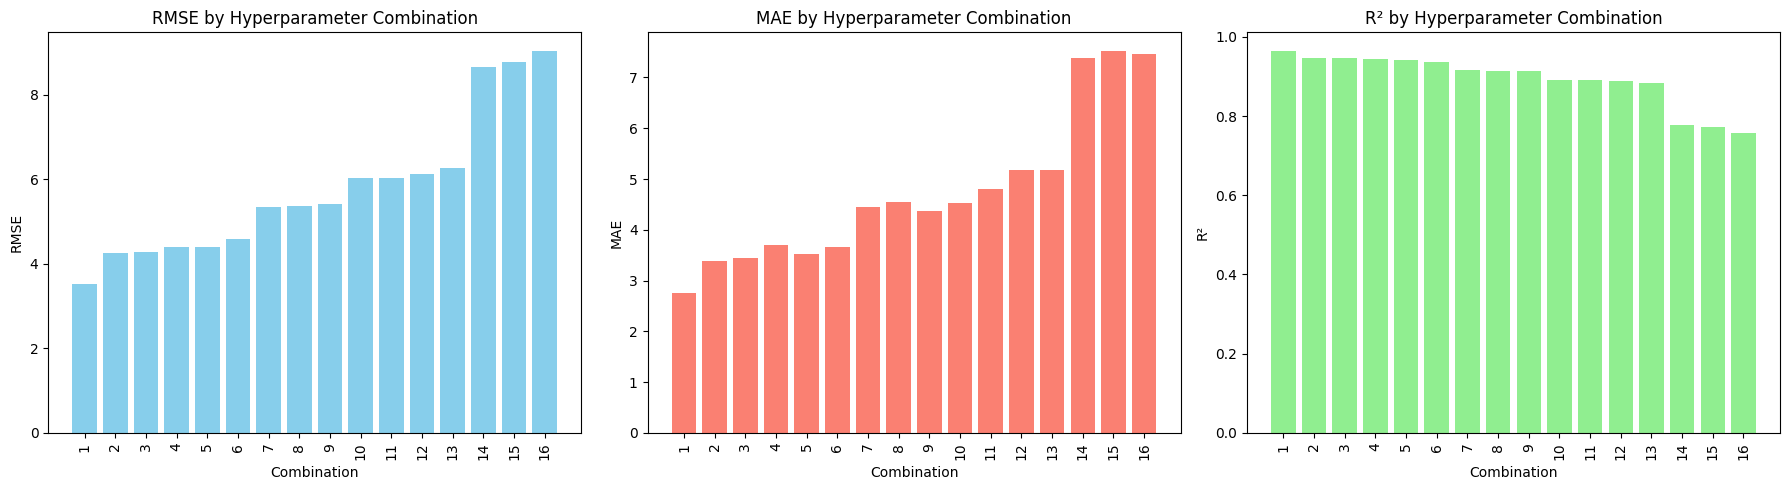

In [31]:
# %%
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results sorted by R² in descending order
results_df_sorted = results_df.sort_values(by='R2', ascending=False)
print("\nHyperparameter Tuning Results:")
print(results_df_sorted)

# %%
# Identify the best hyperparameter combination
best_result = results_df_sorted.iloc[0]
print("\nBest Hyperparameter Combination:")
print(best_result)

# %%
# (Optional) Plot the RMSE, MAE, and R² for each combination
plt.figure(figsize=(18, 5))

# Plot RMSE
plt.subplot(1, 3, 1)
plt.bar(range(len(results_df_sorted)), results_df_sorted['RMSE'], color='skyblue')
plt.title('RMSE by Hyperparameter Combination')
plt.xlabel('Combination')
plt.ylabel('RMSE')
plt.xticks(range(len(results_df_sorted)), range(1, len(results_df_sorted)+1), rotation=90)

# Plot MAE
plt.subplot(1, 3, 2)
plt.bar(range(len(results_df_sorted)), results_df_sorted['MAE'], color='salmon')
plt.title('MAE by Hyperparameter Combination')
plt.xlabel('Combination')
plt.ylabel('MAE')
plt.xticks(range(len(results_df_sorted)), range(1, len(results_df_sorted)+1), rotation=90)

# Plot R²
plt.subplot(1, 3, 3)
plt.bar(range(len(results_df_sorted)), results_df_sorted['R2'], color='lightgreen')
plt.title('R² by Hyperparameter Combination')
plt.xlabel('Combination')
plt.ylabel('R²')
plt.xticks(range(len(results_df_sorted)), range(1, len(results_df_sorted)+1), rotation=90)

plt.tight_layout()
plt.show()


In [32]:
# %%
# Train the Final Model with the Best Hyperparameters on Train + Dev Sets

# Combine Train and Dev sets
X_combined = np.concatenate((X_train, X_dev), axis=0)
y_combined = np.concatenate((y_train, y_dev), axis=0)
print(X_combined.shape)

best_units = int(best_result['units'])
best_dropout = int(best_result['dropout'])
best_batch_size = int(best_result['batch_size'])
best_epochs = int(best_result['epochs'])

print("\nTraining the final model with the best hyperparameters on combined Train + Dev sets:")
print(f"Units: {best_units}, Dropout: {best_dropout}, Batch Size: {best_batch_size}, Epochs: {best_epochs}")

# Build the final model
final_model = Sequential()
final_model.add(LSTM(units=best_units, return_sequences=True, input_shape=(lookback,int(X_combined.shape[2]))))
final_model.add(Dropout(best_dropout))
final_model.add(LSTM(units=best_units, return_sequences=False))
final_model.add(Dropout(best_dropout))
final_model.add(Dense(units=1))  # Predicting a single value

# Compile the final model
final_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the final model
final_history = final_model.fit(
    X_combined, y_combined,
    epochs=int(best_epochs),
    batch_size=int(best_batch_size),
    validation_data=(X_test, y_test),
    shuffle=False,
    verbose=1
)


(916, 5, 25)

Training the final model with the best hyperparameters on combined Train + Dev sets:
Units: 100, Dropout: 0, Batch Size: 32, Epochs: 50
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0070 - val_loss: 0.0248
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0241 - val_loss: 0.0187
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0542
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0298
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0313
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 0.0210
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0153
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0112
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0089
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0076
Epoch 11

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Final Model Evaluation on Test Set:
Root Mean Squared Error (RMSE): 4.9332
Mean Absolute Error (MAE): 3.7650
R² Score: 0.9391


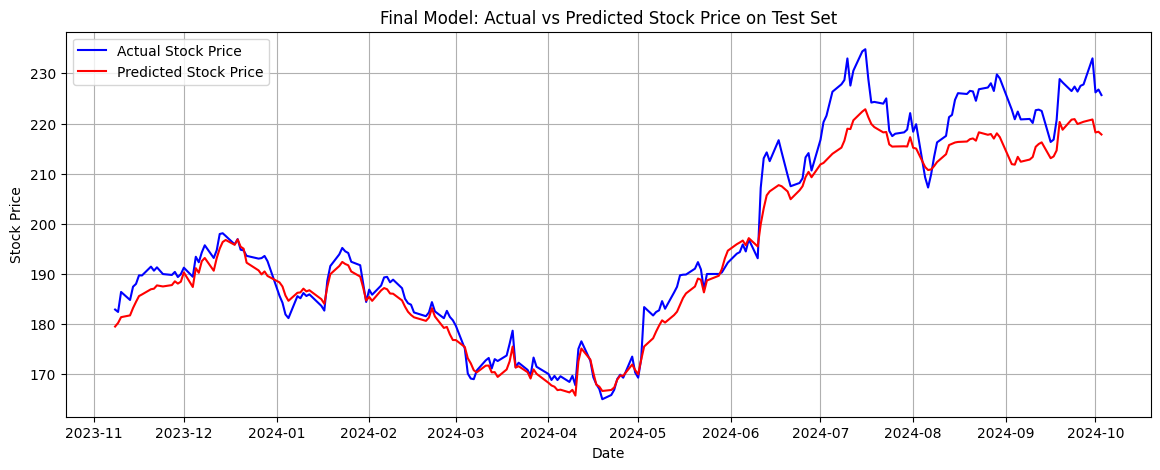

In [35]:
# %%
# Evaluate the Final Model on Test Set
y_test_pred = final_model.predict(X_test)

y_test_pred = final_model.predict(X_test).flatten()  # Flatten to 1D array

# Align dates: Exclude the first (lookback - 1) dates
aligned_dates = X_test_copy.index[lookback - 1:]

# Ensure that the lengths match
assert len(aligned_dates) == len(y_test), "Length mismatch between dates and y_test"

# Create Pandas Series for actual and predicted values with aligned dates
y_test_series = pd.Series(y_test.flatten(), index=aligned_dates, name='Actual_Close')
y_test_pred_series = pd.Series(y_test_pred, index=aligned_dates, name='Predicted_Close')

# Inverse transform predictions and actual values
# Reshape to 2D arrays for inverse_transform
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred_series.values.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_series.values.reshape(-1, 1)).flatten()

# Create Pandas Series for inverse transformed values
y_test_inv_series = pd.Series(y_test_inv, index=aligned_dates, name='Actual_Close_Inv')
y_test_pred_inv_series = pd.Series(y_test_pred_inv, index=aligned_dates, name='Predicted_Close_Inv')


# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
test_mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
test_r2 = r2_score(y_test_inv, y_test_pred_inv)

print(f"\nFinal Model Evaluation on Test Set:")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R² Score: {test_r2:.4f}")

# Plot Actual vs Predicted on Test Set
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv_series, color='blue', label='Actual Stock Price')
plt.plot(y_test_pred_inv_series, color='red', label='Predicted Stock Price')
plt.title('Final Model: Actual vs Predicted Stock Price on Test Set')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()



In [36]:
y_test_pred_inv_series.to_csv('../../data/final_output_data/aaplLSTMpred.csv')